## Obtendo dados
<hr style="border:2px solid #0077b9;">

- Recuperar N focos de queimadas para cada região do Brasil
    - Para cada foco, obter valores de risco, precipitação, temperatura e umidade para o dia do evento
- Explorar dados


In [172]:
# Recuperar N focos de queimadas para cada região do Brasil

from bdq import bdq;
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython.display import display, HTML 
display(HTML("<style>.dataframe{font-size: 16px !important;}</style>"))


b = bdq(wfs_server="http://localhost:8080/geoserver-esensing/", wtss_server="http://localhost:7654")

# recupera 500 focos de cada regiao
N=500
fc_n , _ = b.feature_collection("esensing:focos_bra_2016", attributes=["timestamp","regiao","bioma"], filter="regiao='N'", max_features=N, sort_by='rand')
fc_ne, _ = b.feature_collection("esensing:focos_bra_2016", attributes=["timestamp","regiao","bioma"], filter="regiao='NE'", max_features=N, sort_by='rand')
fc_co, _ = b.feature_collection("esensing:focos_bra_2016", attributes=["timestamp","regiao","bioma"],filter="regiao='CO'", max_features=N, sort_by='rand')
fc_se, _ = b.feature_collection("esensing:focos_bra_2016", attributes=["timestamp","regiao","bioma"],filter="regiao='SE'", max_features=N, sort_by='rand')
fc_s , _ = b.feature_collection("esensing:focos_bra_2016", attributes=["timestamp","regiao","bioma"],filter="regiao='S'", max_features=N, sort_by='rand')

print("Done!")

Done!


In [173]:
# Combinando todos os dados
fc = pd.concat([fc_n, fc_ne, fc_co, fc_se, fc_s], ignore_index=True)
fc.to_pickle('fc.pkl')
display(fc.sample(n=5))

,bioma,coordinates,regiao,timestamp
1715,Mata Atlântica,"[-47.714, -23.001]",SE,2016-08-01T21:29:17Z
2342,Mata Atlântica,"[-50.474, -27.289]",S,2016-06-08T17:05:44Z
1991,Cerrado,"[-45.869, -16.638]",SE,2016-07-13T16:05:14Z
2269,Pampa,"[-51.165, -29.679]",S,2016-07-24T17:40:00Z
131,Cerrado,"[-48.423, -8.376]",N,2016-09-03T16:35:00Z


In [16]:
import pickle
fc = pd.read_pickle('fc.pkl')

In [ ]:
# Para cada foco, obtem o valor de risco, precipitação, temperatura e umidade para o dia da ocorrência
import pickle
df = None
for index, row in fc.iterrows():
    s_date = datetime.strptime(row['timestamp'], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m-%d")
    ts, ts_metadata = b.time_series("rpth", ("risk","precipitation", "temperature", "humidity"), 
                                    row['coordinates'][1], row['coordinates'][0],
                                   start_date=s_date, end_date=s_date)
    ts['bioma'] = row['bioma']
    ts['regiao'] = row['regiao']
    ts['timestamp'] = row['timestamp']
    if df is None:
        df = ts;
    else:
        df = pd.concat([df, ts],ignore_index=True)
df.to_pickle('df.pkl')
print("Done!")

In [18]:
import pickle
df = pd.read_pickle('df.pkl')

## Explorando os dados
<hr style="border:2px solid #0077b9;">

In [64]:
# Overview dos dados

df.describe()

,humidity,precipitation,risk,temperature
count,500.000000,500.000000,5.000000e+02,500.000000
mean,0.375601,0.344547,1.395689e+35,303.447981
std,0.156352,3.560627,1.172460e+36,5.155033
min,0.126972,0.000000,0.000000e+00,284.425110
25%,0.253019,0.000000,7.078235e-01,300.408928
50%,0.341988,0.000000,1.000000e+00,304.940857
75%,0.471613,0.000000,1.000000e+00,307.181709
max,0.990000,77.003990,9.969210e+36,313.200317


In [65]:
# Excluindo valores do data frame

df_b = df[df['risk']<=1]
df_c = df_b[["risk", "precipitation"], "humidity", "temperature"]
df_c.describe()

,humidity,precipitation,risk,temperature
count,493.000000,493.000000,493.000000,493.000000
mean,0.372728,0.349416,0.802090,303.542932
std,0.153829,3.585631,0.320763,5.120481
min,0.126972,0.000000,0.000000,284.425110
25%,0.251844,0.000000,0.700268,300.539154
50%,0.338069,0.000000,1.000000,305.066132
75%,0.466447,0.000000,1.000000,307.201080
max,0.990000,77.003990,1.000000,313.200317


In [66]:
# importando e configurando módulos de plotagem

import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline  

fig_size = (16,5)
palette=sns.diverging_palette(10, 240,  as_cmap=True)

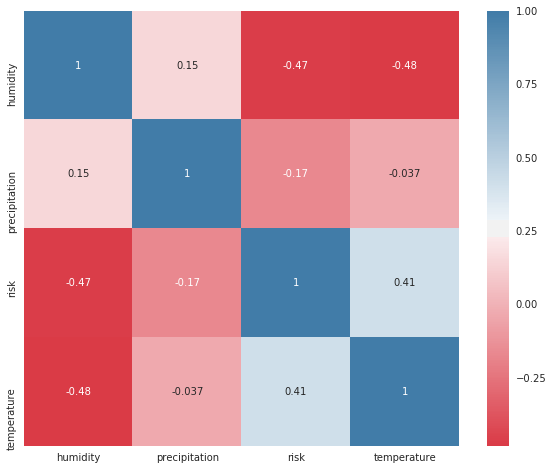

In [96]:
# Gerando matrix de correlação
f, ax = plt.subplots(figsize=(10, 8))
corr = df_c.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=palette,
            square=True, ax=ax, annot=True)


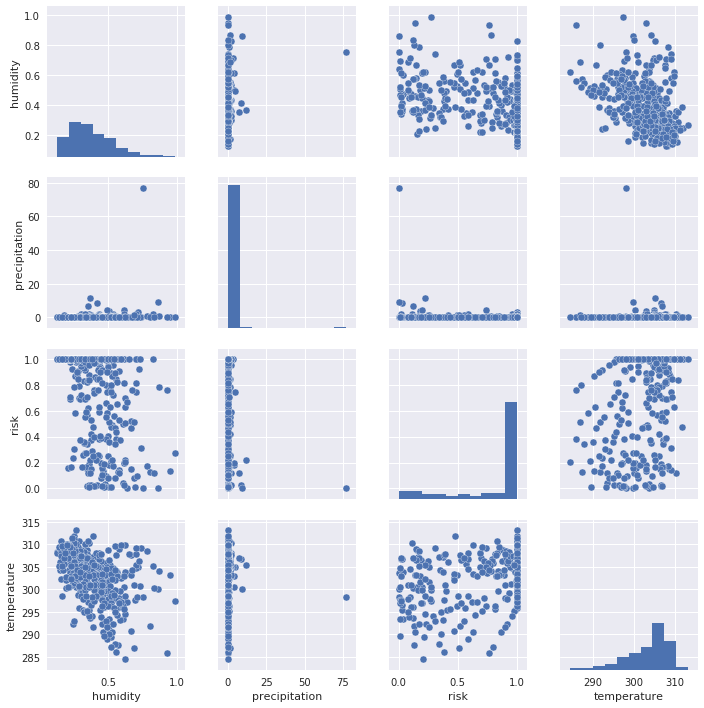

In [68]:
# Gerando scatterplot matrix
sns.pairplot(df_c)

### Por região
<hr style="border:2px solid #0077b9;">

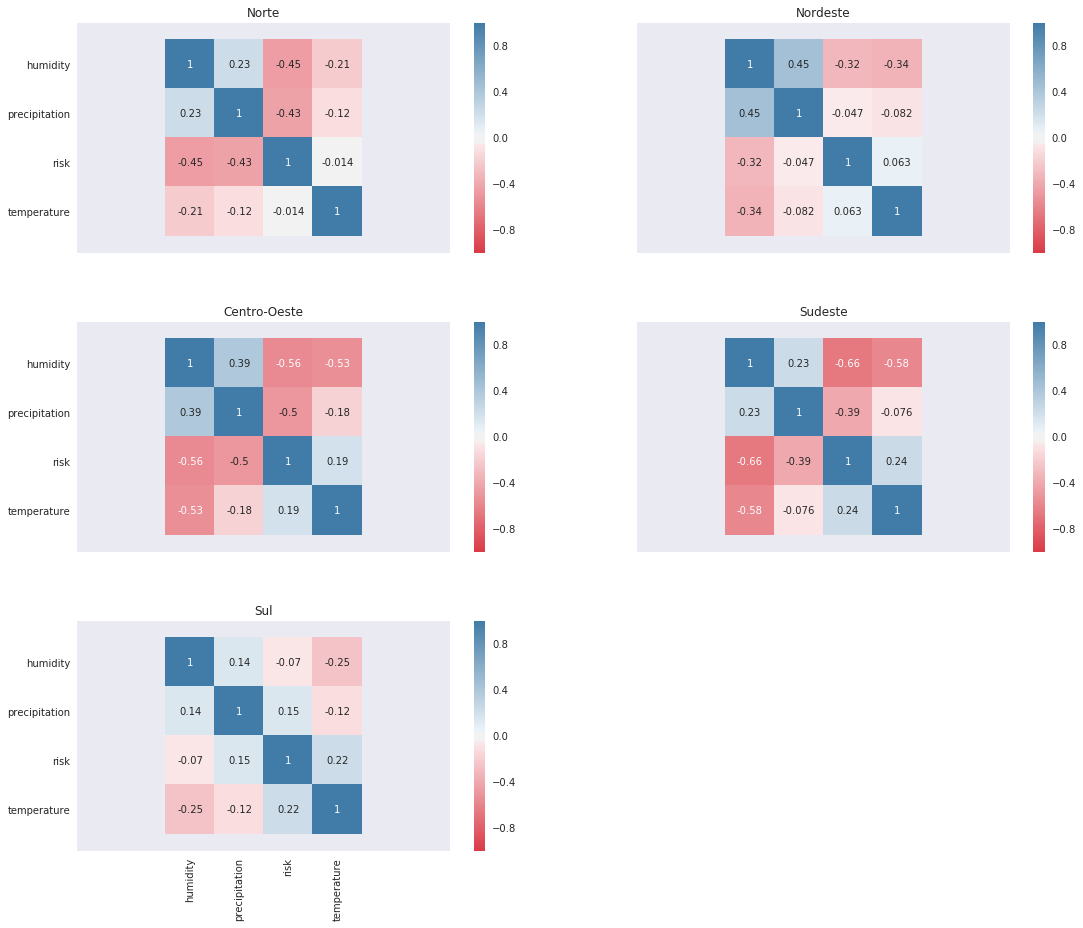

In [112]:
# Gerando matrix de correlação para cada região

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

siglas = ["N ", "NE", "CO", "SE", "S "]
titulos=["Norte", "Nordeste", "Centro-Oeste", "Sudeste", "Sul"]

for i in xrange(0, 5):
    corr = df_c[df_c['regiao']==siglas[i]].corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=palette, square=True, ax=ax[i], annot=True, vmin=-1, vmax=1)
    ax[i].set_title(titulos[i])

ax6.set_visible(False)
plt.subplots_adjust(hspace=0.3, top=3, right=2.5)

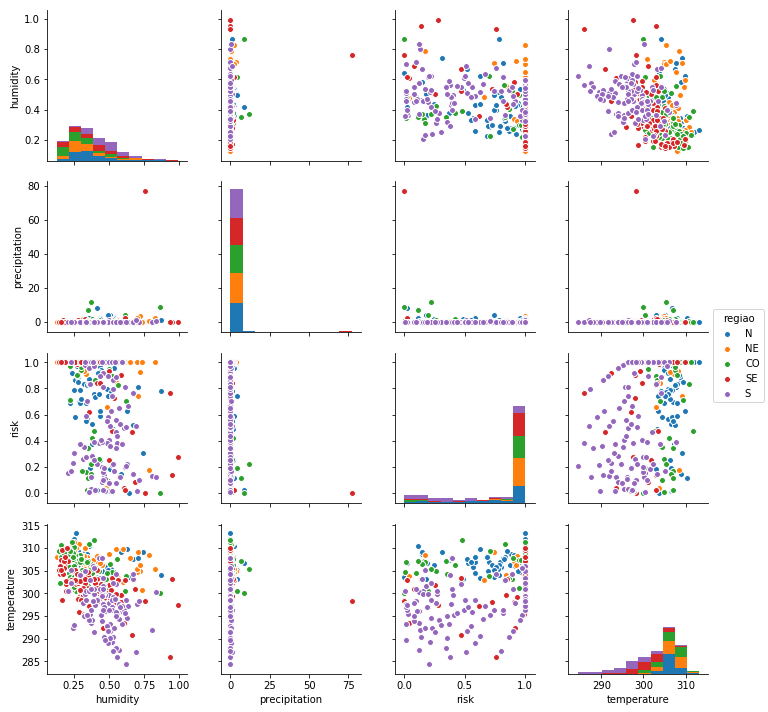

In [27]:
# Gerando scatterplot matrix por região
sns.pairplot(df_c, hue="regiao")

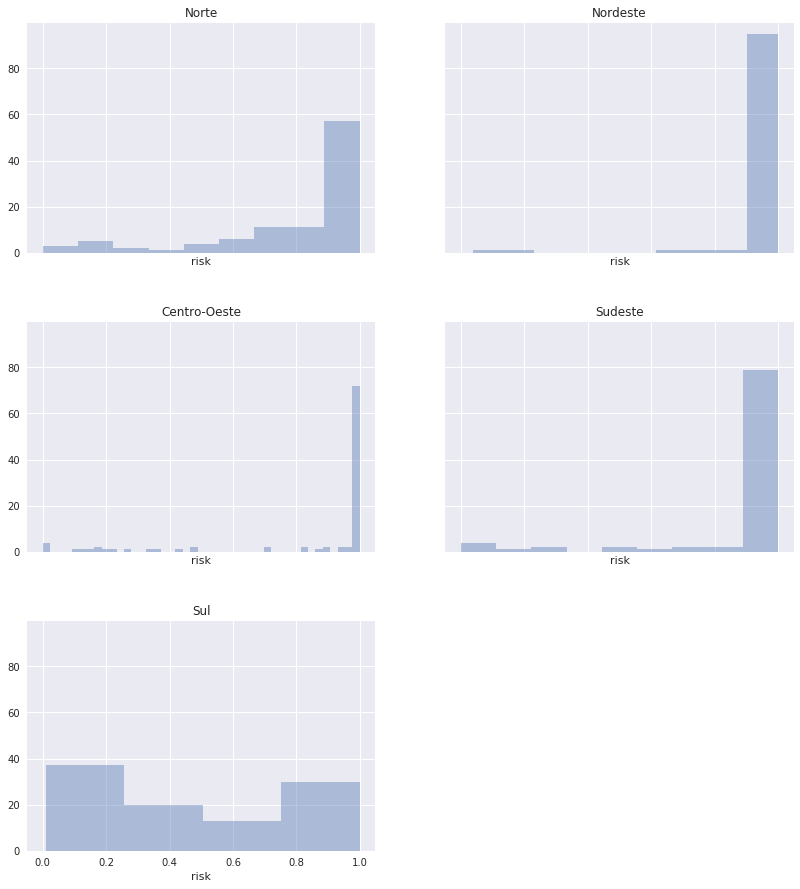

In [136]:
# Histogramas para cada região

from scipy import stats, integrate
sns.set(color_codes=True)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2 , sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in xrange(0, 5):
    sns.distplot(df_c[df_c['regiao']==siglas[i]]["risk"], ax=ax[i], kde=False);
    ax[i].set_title(titulos[i])

ax6.set_visible(False)
plt.subplots_adjust(hspace=0.3, top=3, right=1.9)

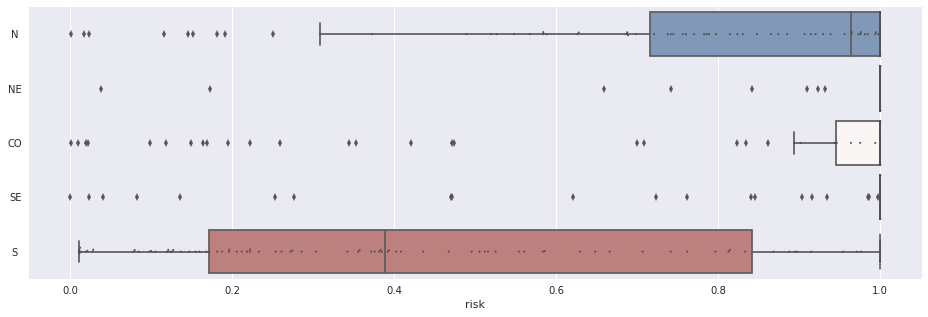

In [113]:
# Gerando boxplot para risco por região
fig, ax = plt.subplots(figsize=fig_size)
sns.boxplot(ax=ax, x="risk", y="regiao", data=df_c, palette="vlag")
sns.swarmplot(x="risk", y="regiao", data=df_c, size=2, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

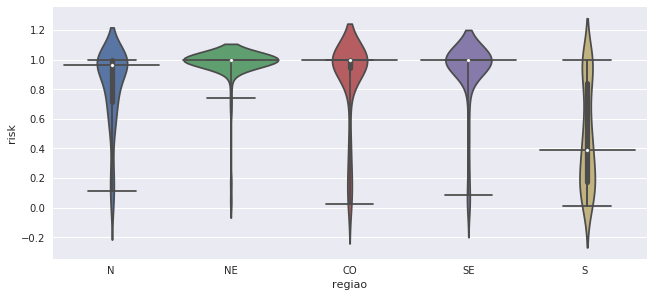

In [164]:
sns.boxplot(x="regiao", y="risk", data=df_c, showfliers=False, showbox=False, whis=[2.5,97.5])
ax = sns.violinplot(x="regiao", y="risk", data=df_c)
plt.subplots_adjust(hspace=0.3, top=1, right=1.5)

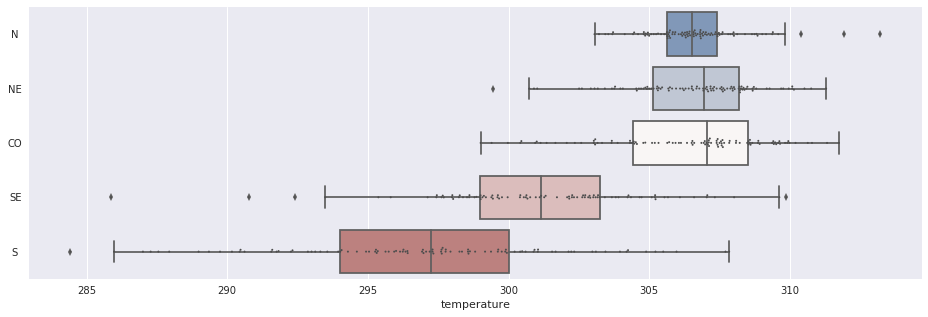

In [114]:
# Gerando boxplot para temperatura por região
fig, ax = plt.subplots(figsize=fig_size)
sns.boxplot(ax=ax, x="temperature", y="regiao", data=df_c, palette="vlag")
sns.swarmplot(x="temperature", y="regiao", data=df_c, size=2, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

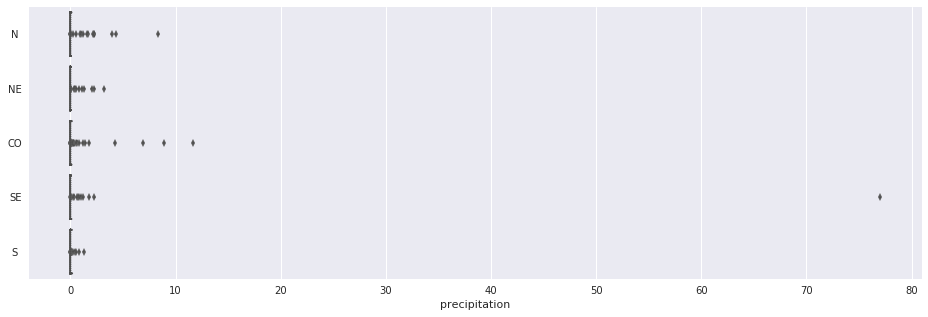

In [115]:
# Gerando boxplot para precipitação por região
fig, ax = plt.subplots(figsize=fig_size)
sns.boxplot(ax=ax, x="precipitation", y="regiao", data=df_c, palette="vlag")
sns.swarmplot(x="precipitation", y="regiao", data=df_c, size=2, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

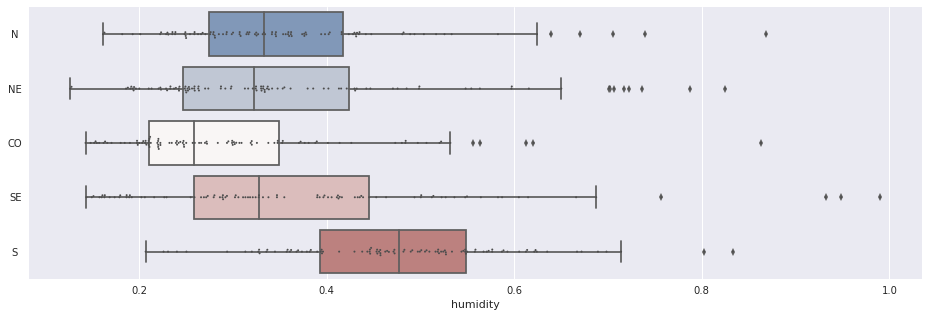

In [116]:
# Gerando boxplot para umidade por região
fig, ax = plt.subplots(figsize=fig_size)
sns.boxplot(ax=ax, x="humidity", y="regiao", data=df_c, palette="vlag")
sns.swarmplot(x="humidity", y="regiao", data=df_c, size=2, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

### Por bioma
<hr style="border:2px solid #0077b9;">

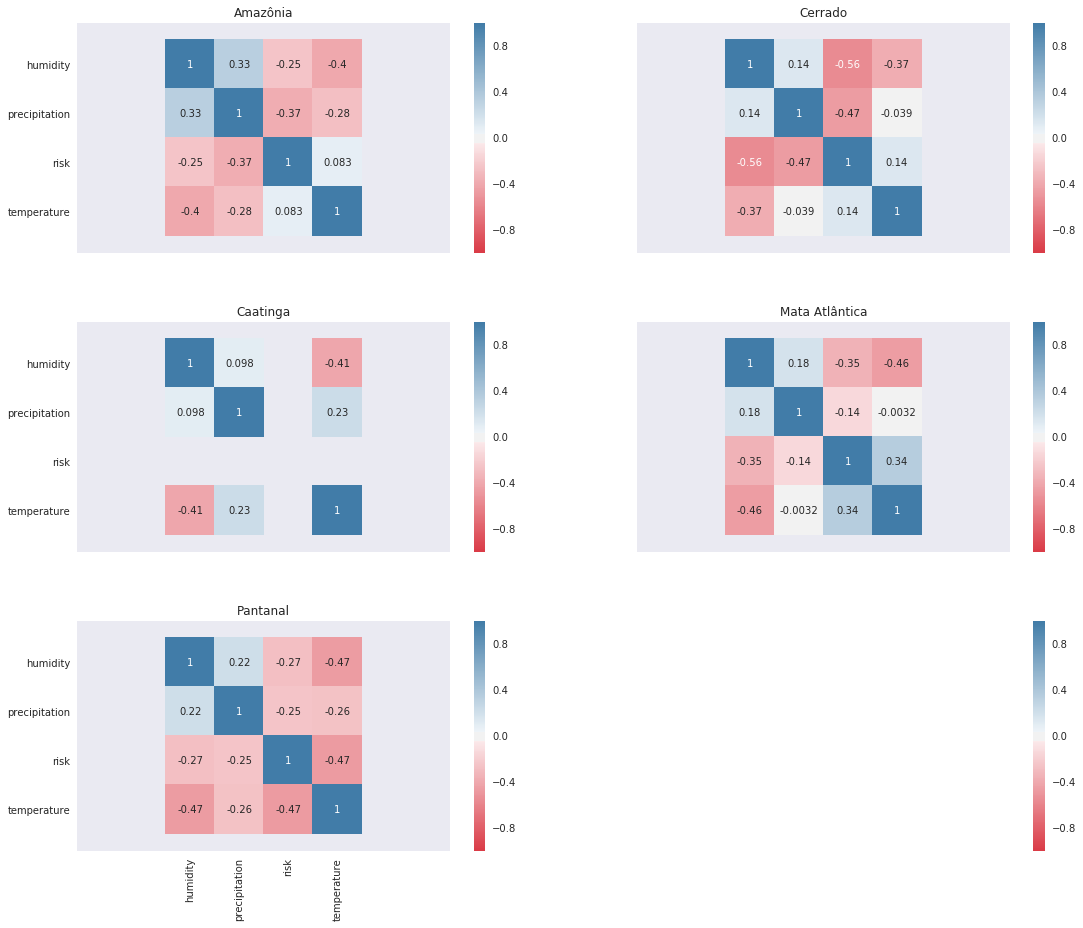

In [122]:
biomas = df_c['bioma'].unique()

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in xrange(0, 6):
    corr = df_c[df_c['bioma']==biomas[i]].corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=palette, square=True, ax=ax[i], annot=True, vmin=-1, vmax=1)
    ax[i].set_title(biomas[i])

ax6.set_visible(False)
plt.subplots_adjust(hspace=0.3, top=3, right=2.5)

In [128]:
# Olhando o caso da Caatinga
pd.DataFrame(df_c[df_c['bioma']=='Caatinga']).describe()

,humidity,precipitation,risk,temperature
count,24.000000,24.000000,24.0,24.000000
mean,0.292830,0.087731,1.0,307.411451
std,0.087132,0.307598,0.0,2.019510
min,0.126972,0.000000,1.0,302.604156
25%,0.237920,0.000000,1.0,306.058510
50%,0.258544,0.000000,1.0,307.410126
75%,0.346899,0.000000,1.0,308.253258
max,0.470764,1.321319,1.0,311.283142


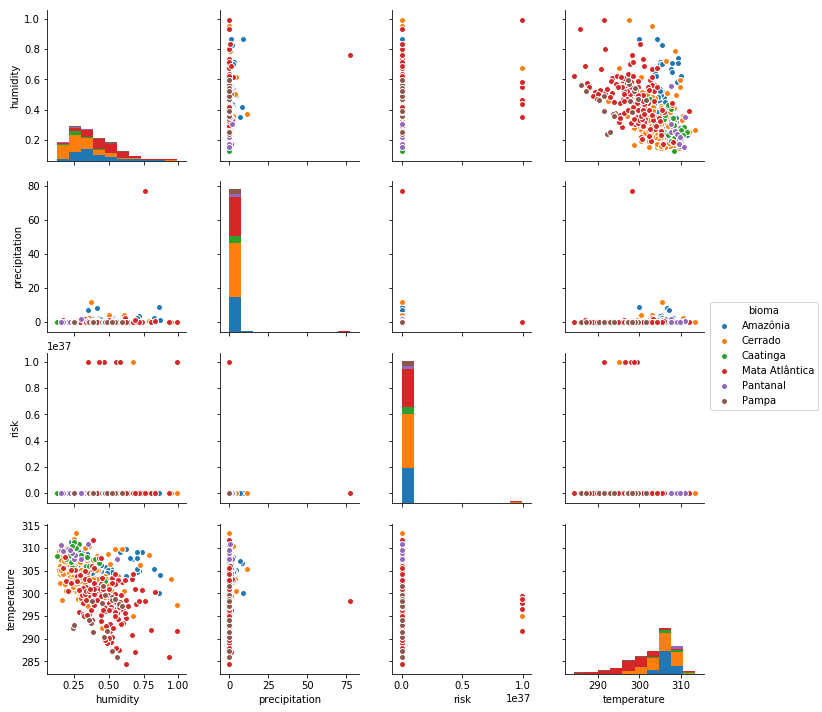

In [28]:
# Gerando scatterplot matrix por bioma
sns.pairplot(df, hue="bioma")

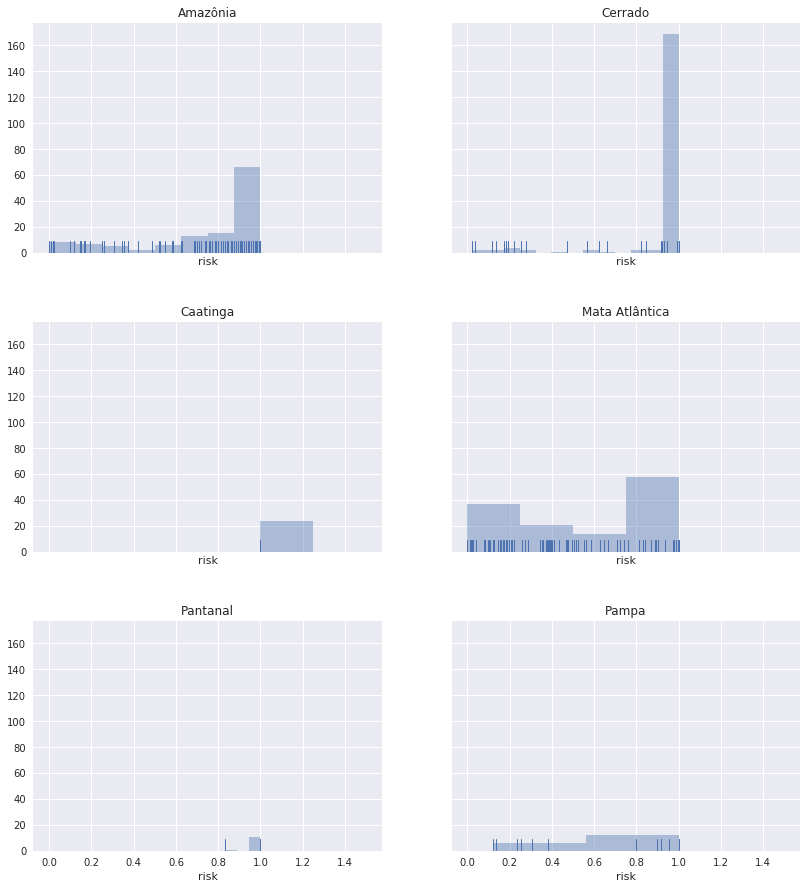

In [147]:
# Histogramas para cada região

from scipy import stats, integrate
sns.set(color_codes=True)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2 , sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in xrange(0, 6):
    sns.distplot(df_c[df_c['bioma']==biomas[i]]["risk"], ax=ax[i], kde=False, rug=True);
    ax[i].set_title(biomas[i])

plt.subplots_adjust(hspace=0.3, top=3, right=1.9)

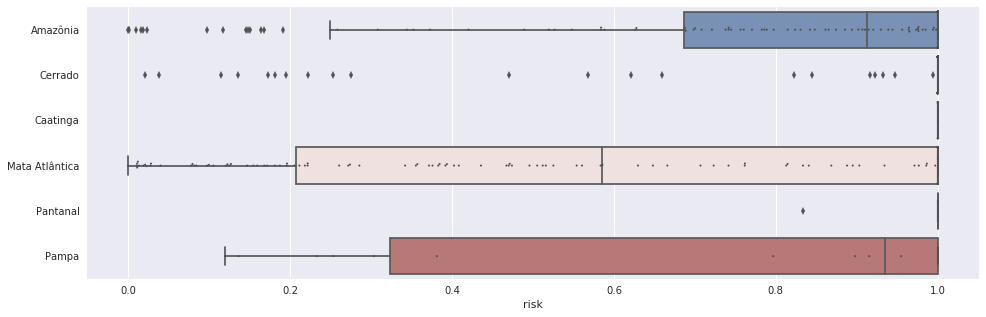

In [148]:
# Gerando boxplot para risco por região
fig, ax = plt.subplots(figsize=fig_size)
sns.boxplot(ax=ax,x="risk", y="bioma", data=df_c, palette="vlag")
sns.swarmplot(x="risk", y="bioma", data=df_c, size=2, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

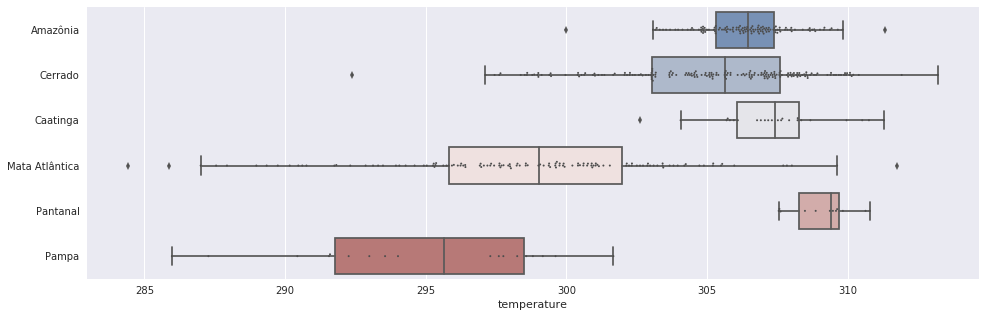

In [149]:
# Gerando boxplot para temperatura por região
fig, ax = plt.subplots(figsize=fig_size)
sns.boxplot(ax=ax,x="temperature", y="bioma", data=df_c, palette="vlag")
sns.swarmplot(x="temperature", y="bioma", data=df_c, size=2, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

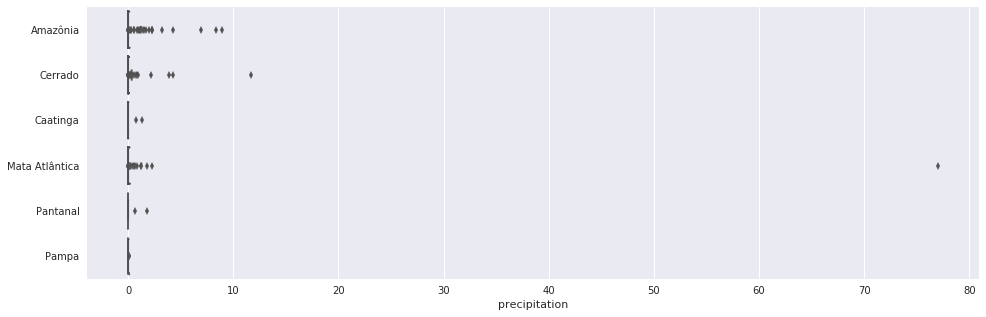

In [150]:
# Gerando boxplot para precipitação por região
fig, ax = plt.subplots(figsize=fig_size)
sns.boxplot(ax=ax,x="precipitation", y="bioma", data=df_c, palette="vlag")
sns.swarmplot(x="precipitation", y="bioma", data=df_c, size=2, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

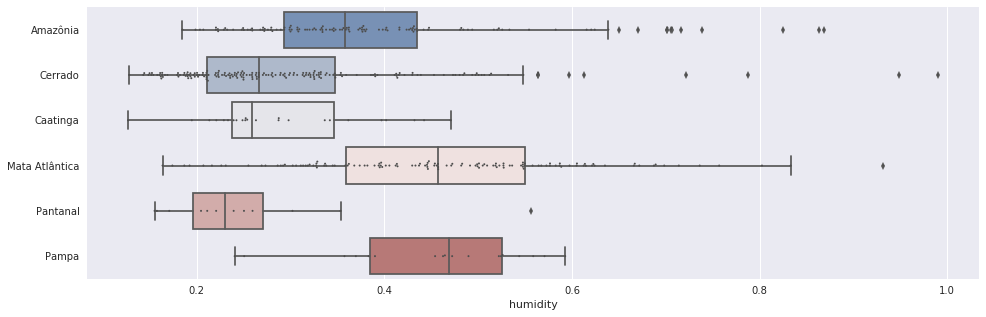

In [151]:
# Gerando boxplot para umidade por região
fig, ax = plt.subplots(figsize=fig_size)
sns.boxplot(ax=ax,x="humidity", y="bioma", data=df_c, palette="vlag")
sns.swarmplot(x="humidity", y="bioma", data=df_c, size=2, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

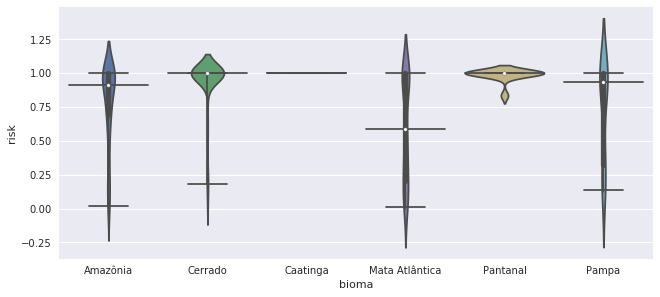

In [162]:
sns.boxplot(x="bioma", y="risk", data=df_c, showfliers=False, showbox=False, whis=[2.5,97.5])
ax = sns.violinplot(x="bioma", y="risk", data=df_c)
plt.subplots_adjust(hspace=0.3, top=1, right=1.5)

## Estações
<hr style="border:2px solid #0077b9;">

# Contando ocorrências

http://walkerke.github.io/geog30323/slides/data-visualization/#/18

Heatmap com x para cada mês e y para cada bioma/estação

Highlighting
http://walkerke.github.io/geog30323/slides/data-visualization/#/highlighting

## Considerações
<hr style="border:2px solid #0077b9;">

### Quanto à análise dos dados
<hr style="border:2px solid #0077b9;">

- O índice de risco funciona bem para as regiões NE, CO e SE
- O índice de risco não representa bem a ocorrência de focos na região S (N+-)
- O índice de risco funciona bem para os biomas Cerrado, Caatinga e Pantanal
- O índice de risco não representa bem a ocorrência de focos nos biomas Mata Atlânica e Pampa (Amazônia)
- Coerente regiões vs Bioma :)
- Como esperado, há pouca precipitação associada aos eventos de focos de queimada

### Quanto à infraestrutura e a disponibilização dos dados
<hr style="border:2px solid #0077b9;">

- Opção de requisição por lotes ao WTSS
- Requisitar série temporal (WTSS) pelo valor (risco = 1)
- Disponibilizar Features de Não Focos
- Disponibilizar outros anos 

## Próximos passos
<hr style="border:2px solid #0077b9;">
- Analisar o comportamento da série temporal (dias anteriores ao evento)
- Avaliar dados de risco = 1 e não foco ('falso positivo')
- Classificar o risco em Baixo, Médio, Moderal, Alto e Extremo considerando as ocorrências de focos (por região, bioma e/ou estação)

## Links
<hr style="border:2px solid #0077b9;">

- BDQ.py: [http://github.com/vconrado/bdq.py/](http://github.com/vconrado/bdq.py/)
- WTSS.py: [https://github.com/e-sensing/wtss.py](https://github.com/e-sensing/wtss.py)
- Trabalho da disciplina: [https://github.com/vconrado/cap-386](https://github.com/vconrado/cap-386)